In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import brute

plt.style.use("seaborn")

In [183]:
class MeanRevertingBacktest():
    def __init__(self, ticker, start, end, sma, dev, ptc=0):
        self.ticker = ticker
        self.start = start
        self.end = end
        self.sma = sma
        self.dev = dev
        self.ptc = ptc
        self.results = None
        self.get_data()

    def __repr__(self):
        return "Ticker: {}, start: {}, end: {}, SMA: {}, StdDev: {}, TradingCost: {}".format(self.ticker, self.start, self.end, self.sma, self.dev, self.ptc)

    def get_data(self):
        df = pd.read_csv("/Users/maxibertonalbornoz/Documents/Python/Udemy/Algorithmic Trading A-Z with Python and ML/Part3_Materials/intraday_pairs.csv", parse_dates=["time"], index_col="time")
        df = df[self.ticker].to_frame().dropna()
        df.rename(columns={self.ticker: "price"}, inplace=True)
        
        df["returns"] = np.log(df.price.div(df.price.shift(periods=1)))
        
        df["SMA"] = df.price.rolling(window=self.sma).mean()
        df["Upper"] = df.SMA + df.price.rolling(window=self.sma).std().mul(self.dev)
        df["Lower"] = df.SMA - df.price.rolling(window=self.sma).std().mul(self.dev)
        df.dropna(inplace=True)
        
        self.data = df
        return df

    def set_parameters(self, sma = None, dev = None):
        if sma is not None:
            self.sma = sma
            self.data["SMA"] = self.data.price.rolling(self.sma).mean()
            self.data["Lower"] = self.data.SMA - (self.data.price.rolling(self.sma).std()).mul(self.dev)
            self.data["Upper"] = self.data.SMA + (self.data.price.rolling(self.sma).std()).mul(self.dev)
            
        if dev is not None:
            self.dev = dev
            self.data["Lower"] = self.data.SMA - (self.data.price.rolling(self.sma).std()).mul(self.dev)
            self.data["Upper"] = self.data.SMA + (self.data.price.rolling(self.sma).std()).mul(self.dev)

    def test_strategy(self):
        data = self.data.copy()

        data["distance"] = np.sign(data.price - data.SMA)

        data["position"] = np.where(data.price > data.Upper, -1, np.nan)
        data["position"] = np.where(data.price < data.Lower, 1, data.position)
        data["position"] = np.where(data.distance.mul(data.distance)<0, 0, data.position)
        data["position"] = data.position.ffill().fillna(0)
        data["trades"] = data.position.sub(data.position.shift(periods=1)).fillna(0).abs()
        
        data["strategy"] = (data.position.shift(periods=1).mul(data.returns)) - data.trades.mul(self.ptc)
        

        data["c_returns"] = data.returns.cumsum().apply(np.exp)
        data["c_strategy"] = data.strategy.cumsum().apply(np.exp)

        self.results = data

        strategy_return = data.c_strategy.iloc[-1]
        outperf = strategy_return - data.c_returns.iloc[-1]

        return strategy_return, outperf

    def plot_returns(self):
        if self.results is None:
            print("There aren't results to plot yet. Please run a strategy first.")
        else:
            title = "Returns for a contrarian strategy in {}. SMA: {}, TC: {}".format(self.ticker, self.sma, self.ptc)
            self.results[["returns", "strategy"]].cumsum().apply(np.exp).plot(title=title, figsize=(15,8))

    def update_and_run(self, boll):
        self.set_parameters(int(boll[0]), int(boll[1]))
        return -self.test_strategy()[0]

    def optimize_parameters(self, sma_range, dev_range):
        opt = brute(self.update_and_run, (sma_range, dev_range), finish=None)
        return opt, -self.update_and_run(opt)

In [184]:
tester = MeanRevertingBacktest(ticker="EURUSD", start="2018-01-01", end="2019-12-30", sma=30, dev=2, ptc=0.00007)

In [185]:
tester

Ticker: EURUSD, start: 2018-01-01, end: 2019-12-30, SMA: 30, StdDev: 2, TradingCost: 7e-05

In [186]:
tester.plot_returns()

There aren't results to plot yet. Please run a strategy first.


In [187]:
tester.test_strategy()

(1.2293806584201792, 0.29213136636294335)

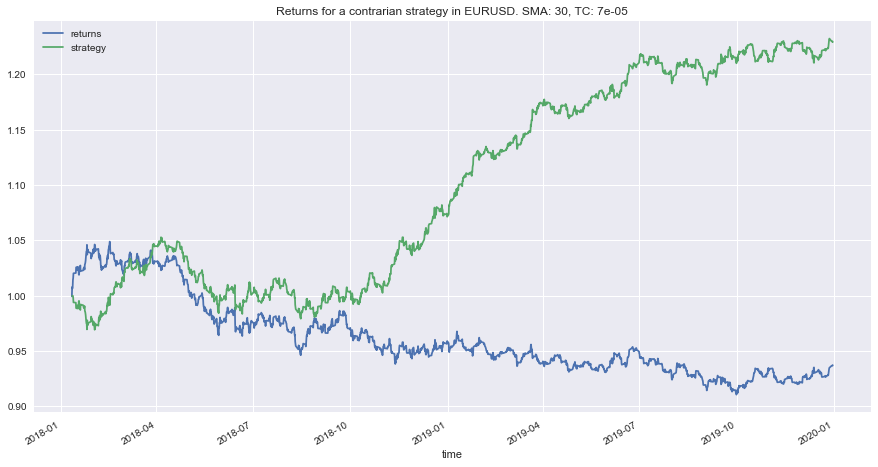

In [188]:
tester.plot_returns()

In [189]:
tester.set_parameters(57, 1)

In [190]:
tester.optimize_parameters((20, 100, 1), (1, 5, 1))

(array([38.,  2.]), 1.3649798915571913)